##### Which aspect of a flight best predicts a customers' overall rating of an airline?

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
warnings.filterwarnings('ignore')

In [11]:
# we open the file for reading
fileObject4 = open("budget.pickle",'rb')

# load the object from the file into variables
df = pickle.load(fileObject4) 

In [12]:
df.head()

,airline_name,author_country,content,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommend,airline,cabin_class,overall
109,51,7,DPS-SIN. Efficient check in and boarding. Flig...,1,8.0,4.0,4.0,4.0,3.0,3.0,3.0,5.0,1,airasia,Economy,4.0
118,59,149,No complaints here. My flight was to Phoenix/M...,1,9.0,4.0,5.0,0.0,0.0,3.0,3.0,5.0,1,allegiant-air,Economy,4.5
130,131,148,This is the 4th Easyjet flight this year flew ...,1,10.0,5.0,5.0,3.0,3.0,3.0,3.0,5.0,1,easyjet,Economy,5.0
172,147,77,I flew with fly540 from to Nairobi to Eldoret ...,1,9.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,1,fly540-com,Economy,4.5
173,146,7,10/8/12 I flew SZB to PEN. It was a short and ...,1,8.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,1,firefly,Economy,4.0


In [13]:
df.columns

Index(['airline_name', 'author_country', 'content', 'cabin_flown',
       'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating',
       'food_beverages_rating', 'inflight_entertainment_rating',
       'ground_service_rating', 'wifi_connectivity_rating',
       'value_money_rating', 'recommend', 'airline', 'cabin_class', 'overall'],
      dtype='object')

In [14]:
formula = 'value_money_rating ~ airline_name + author_country + seat_comfort_rating + cabin_staff_rating + food_beverages_rating + inflight_entertainment_rating + cabin_flown'
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, train_size=.7)

##### ****** Lasso ******

In [16]:
###  Find best alpha using LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)
print(optimal_lasso.alpha_)

###  Cross-validate the Lasso regression  R2  with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_test, y_test, scoring='r2', cv=5)

print(lasso_scores)
print(np.mean(lasso_scores)) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.006031983664883445
[0.53798729 0.512217   0.52967488 0.50904878 0.54588778]
0.5269631480385832


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [17]:
lasso.fit(X_train, y_train)
lasso.predict(X_test)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs

,variable,coef,abs_coef
4,cabin_staff_rating,0.727176,0.727176
3,seat_comfort_rating,0.525881,0.525881
5,food_beverages_rating,0.063375,0.063375
1,airline_name,-0.042143,0.042143
2,author_country,-0.025875,0.025875
6,inflight_entertainment_rating,0.022428,0.022428
0,Intercept,0.000000,0.000000
7,cabin_flown,-0.000000,0.000000


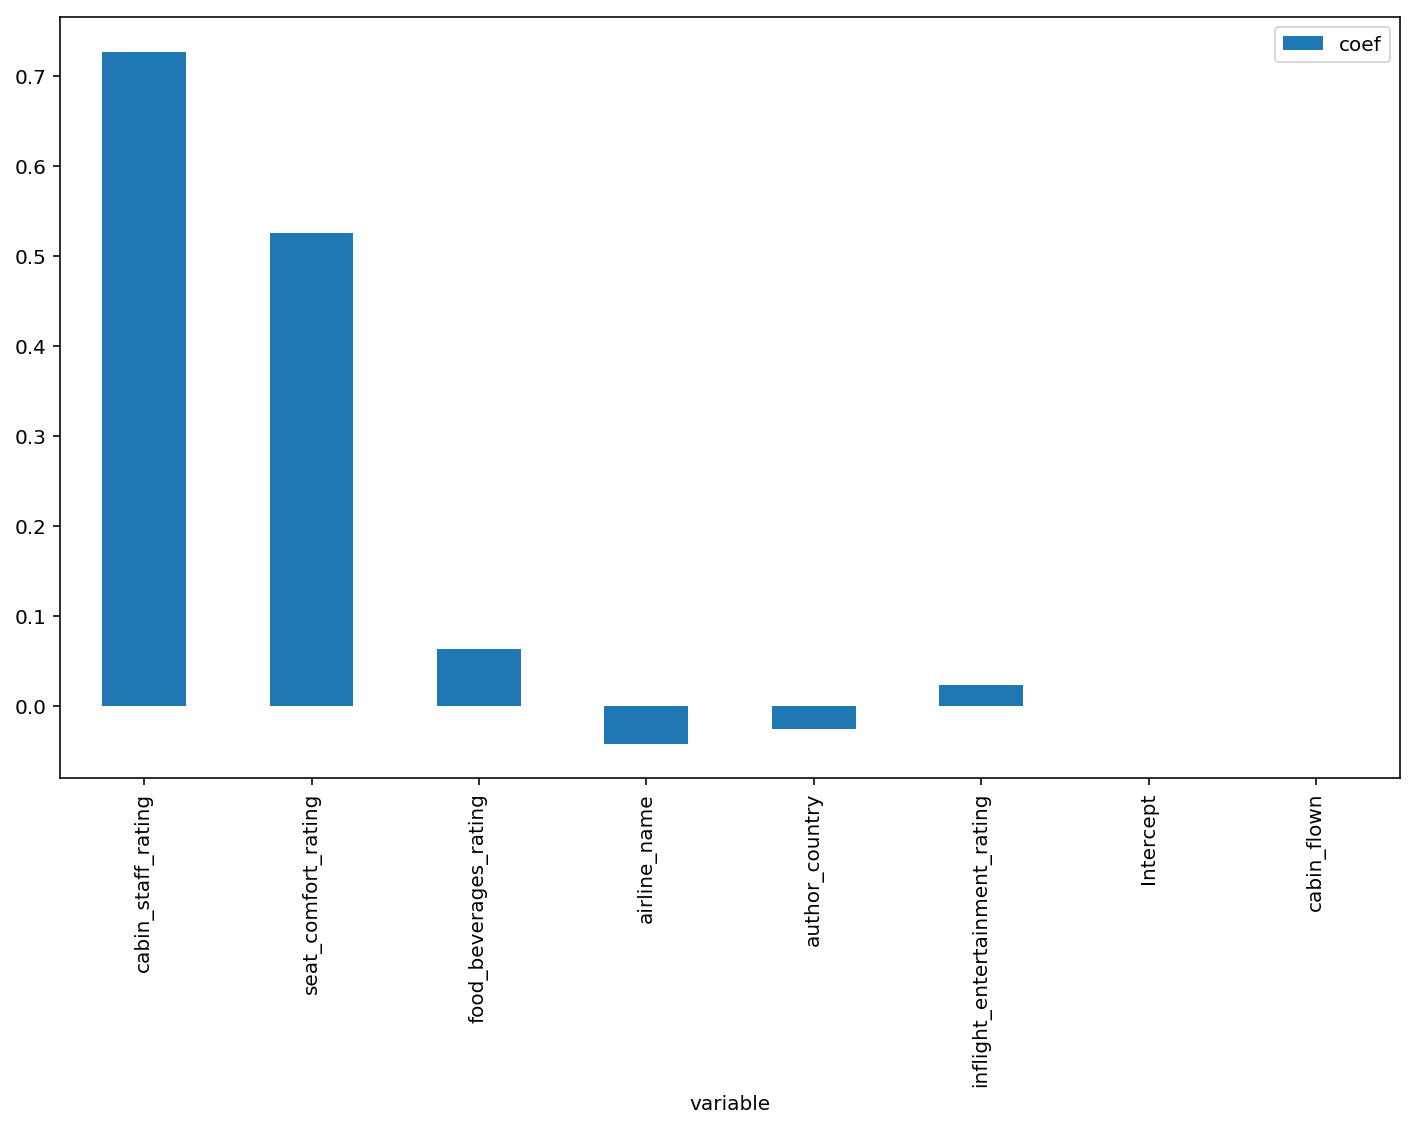

In [18]:
lasso_coefs.plot(kind='bar', x='variable', figsize=(12,7), y='coef')

##### ****  Use GridSearch on Lasso

In [19]:
lasso = Lasso()
parameters = {'alpha':[1e-04,2e-03,0.01,0.1,0.5,0.7,1,2,5], 
              'normalize':[True,False], 
              'tol':[1e-07,1e-06,2e-05,5e-05,1e-04,5e-04,2e-03,1e-02]}

gridsearch_lasso = GridSearchCV(lasso, parameters, cv=5, verbose=1)
gridsearch_lasso.fit(X_train, y_train)

print(gridsearch_lasso.best_score_)
print(gridsearch_lasso.best_estimator_.get_params())

y_pred_lasso1 = gridsearch_lasso.best_estimator_.predict(X_test).reshape(-1,1)

mse_lasso = mean_squared_error(y_test, y_pred_lasso1)
rmse_lasso = np.sqrt(mse_lasso)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5652642626088528
{'alpha': 0.0001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': True, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.002, 'warm_start': False}


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    0.9s finished


In [29]:
scores_lasso = cross_val_score(lasso, X_train, y_train, scoring='explained_variance', cv=5)
print(scores_lasso)
print("Mean:", np.mean(scores_lasso), "Std:", np.std(scores_lasso))
print("RMSE:", rmse_lasso)

[0.1096138  0.11546373 0.10335954 0.10689544 0.10377892]
Mean: 0.10782228664374227 Std: 0.004443538400070982
RMSE: 1.092160804771218


##### ****** ElasticNet ******

In [21]:
###  Find best alpha and l1_ratio using ElasticNetCV
l1_ratios = np.linspace(0.01, 0.035, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=1, cv=5)
optimal_enet.fit(X_train, y_train)
print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_test, y_test, scoring='r2', cv=5)

print(enet_scores)
print(np.mean(enet_scores))

0.0322802732688067
0.035
[0.53694936 0.51257422 0.5296666  0.50989866 0.54452305]
0.5267223799973502


##### ****  Use Random Forest

In [22]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [23]:
print(cross_val_score(rf,X_test,y_test,cv=10,scoring='explained_variance', verbose=False).mean())

0.5149192663117715


In [24]:
rf_param={
    'criterion': ['mse'],
    'max_depth': [80],
    'max_features': ['auto'],
    'n_estimators': [1100,1200,1300],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,param_distributions=rf_param,n_iter=5,cv=8,verbose=2,random_state=5,n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 8 folds for each of 3 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:   25.1s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   26.9s finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'criterion': ['mse'], 'max_depth': [80], 'max_features': ['auto'], 'n_estimators': [1100, 1200, 1300], 'min_samples_leaf': [2], 'min_samples_split': [2]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

'explained_variance'
‘neg_mean_squared_error’
‘neg_mean_absolute_error’
‘neg_mean_squared_log_error’
‘neg_median_absolute_error’

In [25]:
print(rf_random.best_score_)
print(rf_random.best_params_)
model=rf_random.best_estimator_
print(cross_val_score(model,X_test,y_test,cv=8,scoring='explained_variance',verbose=False).mean())

0.5775654175119475
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'mse'}
0.5349948686276844


##### ****  Use RFECV for feature selection

In [26]:
# Use feature selection to identify relevant features
from sklearn.feature_selection import RFECV

rfe_lr = LinearRegression()
rfe1 = RFECV(rfe_lr, step=1, cv=10, n_jobs=-1, verbose=1)
rfe1.fit(X_train, y_train)

print('Number of features selected by RFE: {}'.format(rfe1.n_features_),'\n')
rfe1_list = X.columns[rfe1.support_]

print(rfe1_list,'\n')
print(rfe1.ranking_)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Number of features selected by RFE: 6 

Index(['airline_name', 'author_country', 'seat_comfort_rating',
       'cabin_staff_rating', 'food_beverages_rating',
       'inflight_entertainment_rating'],
      dtype='object') 

[3 1 1 1 1 1 1 2]


##### ****  PCA with Stochastic Gradient Descent

In [28]:
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor

n_list=[x for x in range(1,11,1)]
score_list=[]
for n in range(1,11,1):
    pca = PCA(n_components=n)
    pca.fit(X_train)
    X_train2 = pca.transform(X_train)
    X_test2 = pca.transform(X_test)
    
    sgd_reg = SGDRegressor()
    selector = RFECV(sgd_reg, step=1, cv=5,scoring='r2')
    selector = selector.fit(X_train2, y_train)
    score_list.append(selector.score(X_test2,y_test))
    
print(np.array(score_list).max())
score_list.index(np.array(score_list).max())+1

ValueError: n_components=9 must be between 0 and min(n_samples, n_features)=8 with svd_solver='full'